**Dipole Moment**

In [1]:
from itertools import combinations
import numpy as np
from pyscf import gto
from jqc.mapper.jordan_wigner import JordanWignerMapper

def dipole_moment(mol):
    'Generate the dipole moment in the second quantization form.'
    coords = mol.atom_coords()
    no = 2
    second_q = ''
    for i, j in combinations(range(len(coords)), 2):
        r = np.linalg.norm(coords[i] - coords[j])
        second_q += f'+ {r} {j}^ {i} '
        second_q += f'+ {r} {j + no}^ {i + no} '
    print(second_q)
    return JordanWignerMapper(second_q)

mol = gto.M(atom='H 0 0 0; H 0 0 0.70', basis='sto-3g')

second_q = dipole_moment(mol)

print(second_q)

+ 1.322808287195543 1^ 0 + 1.322808287195543 3^ 2 
+ (0.330702071798886)i YXII + (0.330702071798886) XXII + (0.330702071798886) YYII - (0.330702071798886)i XYII + (0.330702071798886)i IIYX + (0.330702071798886) IIXX + (0.330702071798886) IIYY - (0.330702071798886)i IIXY 


**Transition Matrix element**

In [1]:
from pyscf import gto
from jqc import VQE, VQD, SSVQE
from jqc.ansatz import eUCCSD
from jqc.simulator import QASM
from jqc.measure.dipole_moment import dipole_moment

from pyscf import gto
from jqc import VQE, VQD, SSVQE
from jqc.ansatz import eUCCSD

mol = gto.M(atom='H 0 0 0; H 0 0 0.70', basis='sto-3g')
ssvqe = SSVQE(mol, eUCCSD())
ssvqe.verbose = False

ssvqe.run()

# ssvqe.simulator = QASM()
dipole_moment = dipole_moment(ssvqe.profiles[0])
ssvqe.transition_matrix(dipole_moment)


- (0.250000000000000)i YZXI + (0.250000000000000) YZYI + (0.250000000000000) XZXI + (0.250000000000000)i XZYI - (0.250000000000000)i IYZX + (0.250000000000000) IYZY + (0.250000000000000) IXZX + (0.250000000000000)i IXZY 


TypeError: attribute name must be string, not 'int'

**Molecular Spin Measure**

In [1]:
from pyscf import gto
from jqc import VQE, VQD
from jqc.ansatz import eUCCSD, UCCSD

mol = gto.M(atom='H 0 0 0; H 0 0 0.70', basis='sto-3g')
vqd = VQD(mol, eUCCSD())
vqd.nstates = 3

vqd.run()


Starting VQD Calculation

Ansatz: eUCCSD
Simulator: StateVector
Optimizer: powell
nstates: 3

State 0:


TypeError: unsupported operand type(s) for *: 'dict' and 'dict'

In [7]:
import numpy as np
from qiskit.quantum_info import Statevector
from jqc.mapper.pauli_string import PauliString
from jqc.mapper.pauli_operator import Pauli

x = Pauli('X')
y = Pauli('Y')
z = Pauli('Z')
i = Pauli('I')

qc1 = vqd.profiles[1].circuit
state_vector1 = Statevector.from_instruction(qc1).data.reshape(-1, 1)
state_vector1 = np.round(state_vector1, 5)
operator1 = PauliString([i, i, i, z])
operator2 = PauliString([i, i, z, i])

operator = operator1 * operator2

value = state_vector1.conj().T @ operator.matrix @ state_vector1
print(value)

[[-0.99999496+0.j]]


In [5]:
from jqc.measure.angular_momentum import s_z
from jqc.simulator import StateVector

profile = vqd.profiles[1]

profile.show()

{'state': 1,
 'spin': '0.00',
 'num_orb': 2,
 'num_elec': 2,
 'coeff': array([ 3.14159342e+00, -4.46085073e-08, -2.80649404e+00, -1.57078957e+00]),
 'energy_elec': -1.234420500007531,
 'energy_nucl': 0.7559674441714287,
 'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f3ab8d9ba90>}

In [13]:
import numpy as np
import itertools
from qiskit.quantum_info import Statevector
from jqc.mapper.pauli_string import PauliString
from jqc.mapper.pauli_operator import Pauli


def measure_spin(state_vector):
    # print(state_vector)
    total_spin = 0.

    x = Pauli('X')
    y = Pauli('Y')
    z = Pauli('Z')
    i = Pauli('I')

    qubits = [0, 1, 2, 3]
    combinations = list(itertools.combinations(qubits, 2))
    combinations = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
    combinations = [(0, 0)]
    for idx in combinations:
        operator = {'x': [], 'y': [], 'z': []}
        for k in range(4):
            if k == 0:
                operator['x'].append(x)
                operator['y'].append(y)
                operator['z'].append(z)
            else:
                operator['x'].append(i)
                operator['y'].append(i)
                operator['z'].append(i)
        pauli_string = {'x': PauliString(operator['x']),
                        'y': PauliString(operator['y']),
                        'z': PauliString(operator['z'])}
        print(pauli_string)
        for key, p_string in pauli_string.items():
            spin = state_vector.conj().T @ p_string.matrix @ state_vector
            total_spin += spin
    return float(np.round(total_spin, 4).real)


###
print('T1')
qc1 = vqd.profiles[1].circuit
state_vector1 = Statevector.from_instruction(qc1).data.reshape(-1, 1)
state_vector1 = np.round(state_vector1, 5)
spin_measure1 = measure_spin(state_vector1)
print(spin_measure1)

# qc.draw('mpl')

print('\nS1')
qc2 = vqd.profiles[2].circuit
state_vector2 = Statevector.from_instruction(qc2).data.reshape(-1, 1)
state_vector2 = np.round(state_vector2, 5)
spin_measure2 = measure_spin(state_vector2)
print(spin_measure2)

print('\nS0')
qc0 = vqd.profiles[0].circuit
state_vector0 = Statevector.from_instruction(qc0).data.reshape(-1, 1)
state_vector0 = np.round(state_vector0, 5)
spin_measure0 = measure_spin(state_vector0)
print(spin_measure0)


T1
{'x': + XIII, 'y': + YIII, 'z': + ZIII}
1.0

S1
{'x': + XIII, 'y': + YIII, 'z': + ZIII}
-1.0

S0
{'x': + XIII, 'y': + YIII, 'z': + ZIII}
-0.9781


[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
(-1+0j)


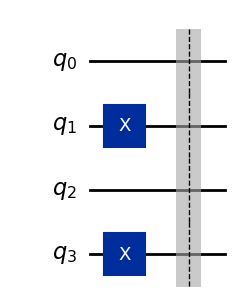

In [49]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

qc = QuantumCircuit(4)

qc.x(1)
qc.x(3)
qc.barrier()

# qc.h(0)
# for i in range(3):
#     qc.cx(i, i + 1)
# qc.z(3)
# for i in reversed(range(3)):
#     qc.cx(i, i + 1)
# qc.h(0)

state_vector = Statevector.from_instruction(qc).data
print(state_vector)


pauli_x = np.array([[0, 1], [1, 0]])
pauli_z = np.array([[1, 0], [0, -1]])
pauli_y = np.array([[0, -1j], [1j, 0]])
pauli_i = np.eye(2)

operator_z = np.kron(pauli_z, np.kron(pauli_i, np.kron(pauli_z, pauli_i)))
operator_x = np.kron(pauli_x, np.kron(pauli_i, np.kron(pauli_x, pauli_i)))
operator_y = np.kron(pauli_y, np.kron(pauli_i, np.kron(pauli_y, pauli_i)))

operator = operator_z + operator_x + operator_y

spin_measure = state_vector.conj().T @ operator @ state_vector
print(spin_measure)

qc.draw('mpl')
